# Market Model

An artificial cryptocurrency market, experimenting the effects of social networks on price dynamics

In [43]:
from model import MarketModel
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import networkx as nx
from ipywidgets import widgets
from IPython.display import display
from cycler import cycler

### Parameters
#### Model-Wide
- $\text{Agents}$ = Number of agents (30% are Random Traders)
- $\text{Price}$ = Initial Starting Price
- $\text{Timesteps}$ = Total Time-Steps

#### Agent-Wide
- $\alpha$ = Sensitivity of price movement
- $\beta$ = Deviation of expected price
- $\gamma$ = Upper bound of Time Horizon (Uniformly Distributed)

#### Decision Making
- $\rho$ = Logit Temperature Parameter
##### *Network* (a list [type, n, p])
- $\text{Network}$ = Network Type (regular, random, smallworld, barabasi & none)
- $n$ = 


In [44]:
agents = 100
non_random = 0.8
timesteps = 500
price= 50

alpha = 0.002
beta = 0.001
gamma = 20
rho = 200

network = ["smallworld", 4, 0.2]

#agents = widgets.IntSlider(description="Agents:", min=10, max=200, step=10, value = 20)
#price = widgets.IntText(value=50,description='Price:')
#timesteps = widgets.IntSlider(description="Agents:", min=10, max=200, step=10, value = 20)
#display(price, agents)

In [45]:
model = MarketModel(agents=agents, non_random=non_random, 
                    price=price, alpha=alpha,
                    beta=beta, gamma=gamma, rho=rho, 
                    network=network)

for i in range(timesteps):
    model.step()

df_model = model.data.get_model_vars_dataframe()
df_agent = model.data.get_agent_vars_dataframe()

## Market Data

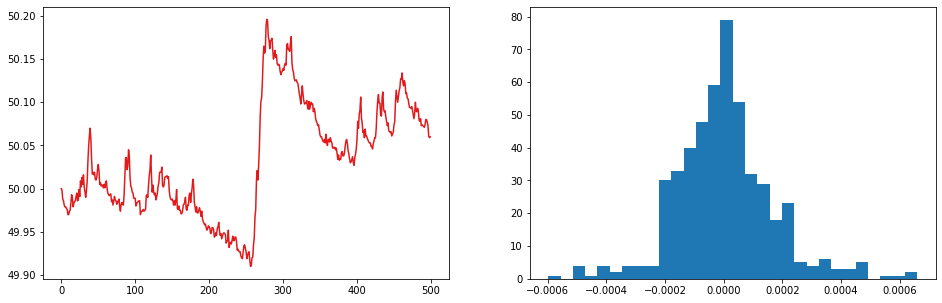

In [46]:
#plt.style.use(['science','ieee', 'retro'])
plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('Paired').colors)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
price = df_model["Price"]
pct_change = np.log(1+df_model["Price"].pct_change().dropna())
mu, std = norm.fit(pct_change) 

fig, ax = plt.subplots(1, 2, figsize=(16,5))
ax[0].plot(price, color=cycle[5])
ax[1].hist(pct_change, bins = 30, color = cycle[1])
plt.show()

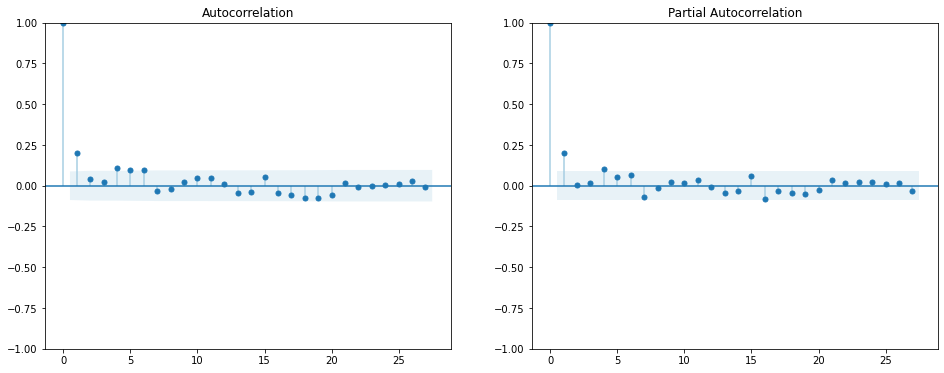

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
plot_acf(pct_change, ax=ax[0], color=cycle[1])
plot_pacf(pct_change, ax=ax[1], method = "ywm", color=cycle[1])
plt.show()

## Herding

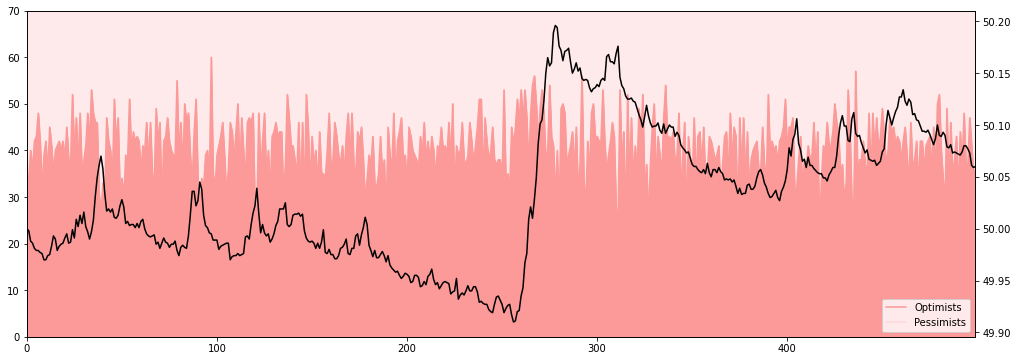

In [48]:
herding_df = pd.DataFrame()
for i in range(1,timesteps+1):
    type_df = df_agent.xs(i)['Trading Type'].value_counts(sort=False)
    herding_df = herding_df.append(type_df, ignore_index=True)
    
x = herding_df.index.tolist()
fig, ax = plt.subplots(figsize=(17,6))
labels = ['Optimists', 'Pessimists']
colors = [cycle[4], cycle[4]+(0.2,)]
herding_df[['OPTIMIST', 'PESSIMIST']].plot.area(ax=ax, color=colors)
price.plot(secondary_y=True, color='black', ax=ax)
ax.legend(loc='lower right', labels=labels)
ax.margins(x=0)
ax.set_ylim(0,agents*0.7)
plt.show()

## Network Information

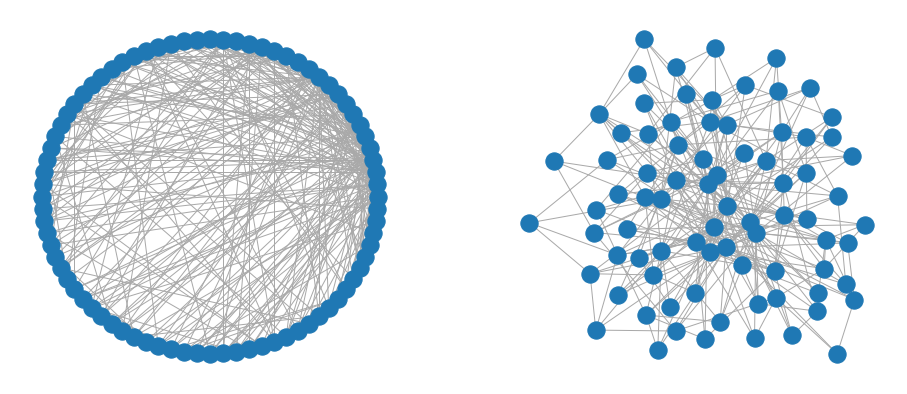

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(16,7))

nx.draw(model.network, ax=ax[1], edge_color='darkgrey')
nx.draw_circular(model.network, ax=ax[0], edge_color='darkgrey')

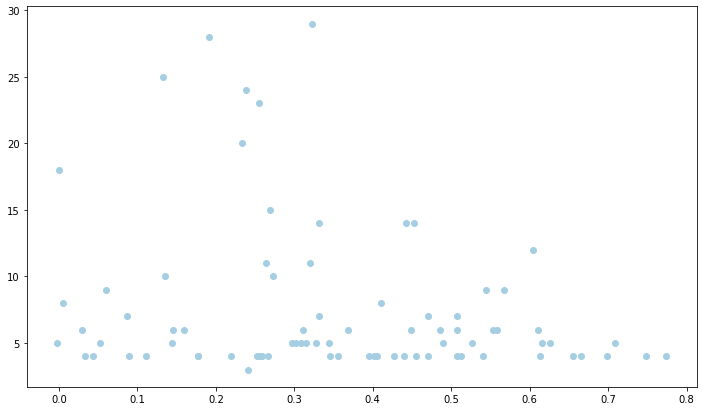

In [50]:
degree = []
rtn = []

for i in range(int(non_random*agents)):
    degree.append(nx.degree(model.network)[i])
    rtn.append(df_agent.xs(i, level=1)[['Previous Return']].sum()[0])
d = {'Degree':degree, 'Return':rtn}
profit_df = pd.DataFrame(data=d)

fig, ax = plt.subplots(figsize=(12,7))
ax.scatter(d['Return'], d['Degree'])
plt.show()

## Tests

In [51]:
from scipy.stats import shapiro
shapiro(pct_change)

ShapiroResult(statistic=0.9625924229621887, pvalue=5.912626499515738e-10)

In [52]:
df_agent.xs(2, level=1)[:20].round(3)

,Trading Type,Horizon,Action,Price,Expectation,Exp Return,Fitness,Previous Return,opt,pess,prob,rng
Step,,,,,,,,,,,,
1,PESSIMIST,5,Action.NOTHING,50.000,50.000,0.000,0.000,0.000,-0.000,-0.000,0.512,0.814
2,OPTIMIST,5,Action.NOTHING,49.998,49.999,0.001,0.000,0.000,-0.001,-0.001,0.504,0.103
3,PESSIMIST,5,Action.NOTHING,49.988,49.984,0.004,0.003,0.000,-0.001,-0.004,0.622,0.797
4,OPTIMIST,5,Action.NOTHING,49.986,49.990,0.004,0.003,0.000,-0.003,-0.002,0.454,0.305
5,PESSIMIST,5,Action.NOTHING,49.981,49.978,0.003,0.002,0.000,-0.002,-0.001,0.455,0.622
6,PESSIMIST,5,Action.NOTHING,49.979,49.985,-0.006,-0.004,0.000,-0.002,-0.004,0.568,0.640
7,OPTIMIST,5,Action.NOTHING,49.979,49.981,0.002,0.001,0.000,-0.002,-0.001,0.450,0.157
8,OPTIMIST,5,Action.NOTHING,49.977,49.974,-0.003,-0.002,0.000,-0.002,-0.001,0.447,0.070
9,PESSIMIST,5,Action.BID,49.976,49.976,-0.000,-0.000,0.000,-0.002,-0.002,0.534,0.700


## Agent Data

In [53]:
df_agent.xs(2, level=1)[:20].round(3) #A specific agent over time

,Trading Type,Horizon,Action,Price,Expectation,Exp Return,Fitness,Previous Return,opt,pess,prob,rng
Step,,,,,,,,,,,,
1,PESSIMIST,5,Action.NOTHING,50.000,50.000,0.000,0.000,0.000,-0.000,-0.000,0.512,0.814
2,OPTIMIST,5,Action.NOTHING,49.998,49.999,0.001,0.000,0.000,-0.001,-0.001,0.504,0.103
3,PESSIMIST,5,Action.NOTHING,49.988,49.984,0.004,0.003,0.000,-0.001,-0.004,0.622,0.797
4,OPTIMIST,5,Action.NOTHING,49.986,49.990,0.004,0.003,0.000,-0.003,-0.002,0.454,0.305
5,PESSIMIST,5,Action.NOTHING,49.981,49.978,0.003,0.002,0.000,-0.002,-0.001,0.455,0.622
6,PESSIMIST,5,Action.NOTHING,49.979,49.985,-0.006,-0.004,0.000,-0.002,-0.004,0.568,0.640
7,OPTIMIST,5,Action.NOTHING,49.979,49.981,0.002,0.001,0.000,-0.002,-0.001,0.450,0.157
8,OPTIMIST,5,Action.NOTHING,49.977,49.974,-0.003,-0.002,0.000,-0.002,-0.001,0.447,0.070
9,PESSIMIST,5,Action.BID,49.976,49.976,-0.000,-0.000,0.000,-0.002,-0.002,0.534,0.700


In [54]:
df_agent.xs(1)[:] #All Agents by Timestep

,Trading Type,Horizon,Action,Price,Expectation,Exp Return,Fitness,Previous Return,opt,pess,prob,rng
AgentID,,,,,,,,,,,,
0,OPTIMIST,19,Action.NOTHING,50.0,49.998362,-0.001638,-0.001441,0.0,0.000210,0.000139,0.503536,0.216847
1,PESSIMIST,10,Action.BID,50.0,50.001489,-0.001489,-0.000927,0.0,-0.000043,-0.000044,0.500083,0.762319
2,PESSIMIST,5,Action.NOTHING,50.0,49.999665,0.000335,0.000217,0.0,-0.000022,-0.000262,0.511953,0.814483
3,PESSIMIST,2,Action.NOTHING,50.0,49.999074,0.000926,0.000588,0.0,-0.000059,0.000035,0.495291,0.599036
4,PESSIMIST,4,Action.BID,50.0,50.000839,-0.000839,-0.000704,0.0,-0.000355,0.000237,0.470458,0.520006
...,...,...,...,...,...,...,...,...,...,...,...,...
95,RANDOM,12,Action.NOTHING,50.0,50.000693,-0.000693,-0.000639,0.0,0.000000,0.000000,0.000000,0.000000
96,RANDOM,12,Action.BID,50.0,49.999394,0.000606,0.000259,0.0,0.000000,0.000000,0.000000,0.000000
97,RANDOM,8,Action.NOTHING,50.0,50.000344,-0.000344,-0.000106,0.0,0.000000,0.000000,0.000000,0.000000


In [55]:

G = nx.watts_strogatz_graph(50,3,1)
Y = nx.newman_watts_strogatz_graph(30,1,0.002)
B = nx.barabasi_albert_graph(100, 1)

In [56]:
G = nx.windmill_graph(50,)
nx.draw(G)

TypeError: windmill_graph() missing 1 required positional argument: 'k'

In [ ]:
nx.draw(Y)